# Coarse Variable Alignment

In [ ]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.analysis
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize
import sklearn.metrics.pairwise

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

In [ ]:
def get_test_matrix(a, n, num_sweeps, num_examples: int = None):
    level = hm.repetitive.hierarchy.create_finest_level(a)
    x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
    return x

def rotation(t):
    c, s = np.cos(t), np.sin(t)
    return np.array([[c, s], [-s, c]])

def get_local_rotation_min_function(X, Y, t, scale=False, p=2):
    if scale:
        scale_x = (0.5 * (norm(X[:, 0]) + norm(X[:, 1]))) ** 0.5
        scale0 = norm(Y[:, 0]) ** 2 * scale_x
        scale1 = norm(Y[:, 1]) ** 2 * scale_x
    else:
        scale0 = scale1 = 1
    return \
        norm( np.cos(t) * X[0] + np.sin(t) * X[1] - Y[0]) ** p / scale0 + \
        norm(-np.sin(t) * X[0] + np.cos(t) * X[1] - Y[1]) ** p / scale1

def get_local_rotation_angle(X, Y):
    return optimize.minimize_scalar(lambda t: get_local_rotation_min_function(X, Y, t),
                                    bounds=(-np.pi, np.pi), method='brent').x

def get_local_rotation_angles(xc, n, aggregate_size, nc):
    num_coarse = nc * (n // aggregate_size)
    return np.array([get_local_rotation_angle(xc[i:i + nc], xc[np.arange(i + nc, i + 2 * nc) % num_coarse])
                     for i in range(0, num_coarse, nc)])

## Problem Parameters

In [ ]:
n = 64
kh = 0.5
num_examples = 20
num_sweeps = 80

np.random.seed(0)
a = hm.linalg.helmholtz_1d_operator(kh, n).tocsr()
level = hm.repetitive.hierarchy.create_finest_level(a)

## Ideal Test Functions
Use $\cos(k' x), sin(k' x)$ where $k'$ is periodic over the domain with the smallest residual (i.e., the smallest-eigenvalue-magnitude eigenvector).

In [ ]:
def fourier_component(n, l, shift=0, kind=0):
    L = n
    h = 1
    x = np.linspace(0, L - h, n)
    theta = 2 * np.pi * l / n
    func = np.cos if kind == 0 else np.sin
    return func(theta * (x + shift) / h)

print("Continuous kh", kh, "wavelength", (2 * np.pi) / kh)

# Smallest eigenvectors by eigendecomposition of A^h.
X, lam = helmholtz.analysis.ideal.ideal_tv(a, 2)
print("Discrete Eigen lam", lam[:8])

# Smallest eigenvector by Fourier analysis.
t = (2 * np.pi / n) * np.arange(-n // 2, n // 2)
L0 = (kh)**2 - t ** 2
# 2nd order FD discretization.
Lh = (kh)**2 + (-2 + 2*np.cos(t))
# 4th order FD discretization.
# Lh = (kh)**2 + (-30 + 32*np.cos(t) - 2*np.cos(2*t)) / 12

ind = np.argmin(np.abs(Lh))

l = ind - n // 2
v0 = fourier_component(n, l, kind=0)
v1 = fourier_component(n, l, kind=1)
print("Discrete LFA", "l", l, "ind", ind, "theta", t[ind], "wavelenth", 
      (2 * np.pi) / np.abs(t[ind]), n / np.abs(l), "Lh", Lh[ind], 
      "RQ", v0.dot(a.dot(v0)) / (v0.dot(v0)), "RQ", v1.dot(a.dot(v1)) / (v1.dot(v1)))

# Generate TVs by translating the 2 smallest eigenvectors by random shifts.
wavelength = n / np.abs(l)
x = []
shifts = [0] + wavelength * np.random.random(size=num_examples // 2)
print(wavelength, shifts)
for shift in shifts:
    x.append(fourier_component(n, l, shift, kind=0))
    x.append(fourier_component(n, l, shift, kind=1))
x = np.array(x).transpose()

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
ax = axs[0]
ax.plot(t, L0, label="$\hat{L}$")
ax.plot(t, Lh, label="$\hat{L}^h$")
ax.legend();
ax.set_title("Symbol")
ax.grid(True);

ax = axs[1]
L = n
h = 1
x_coord = np.linspace(0, L - h, n)
ax.plot(x_coord, v0);
ax.plot(x_coord, v1);
ax.set_title("Fourier Components")
ax.grid(True);

ax = axs[2]
ax.set_title("Smallest Eigenvectors")
ax.plot(X[:, 0])
ax.plot(X[:, 1])
ax.grid(True);

In [ ]:
# Generate relaxed test matrix.
x = get_test_matrix(a, n, num_sweeps, num_examples=20)

## Create a Coarsening Matrix $R$

In [ ]:
# Use only the first 4 vectors to extract windows. Should suffice for this large n.
x_windows = x[:, :4]
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
max_conv_factor = 0.3
coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x_windows, aggregate_size_values, 4, repetitive=True)
r, aggregate_size, nc = coarsener.get_optimal_coarsening(max_conv_factor, aggregate_size=4)[:3]
print("Coarsening", "a", aggregate_size, "nc", nc)
xc = r.dot(x)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

ax = axs[0]
for i in range(2):
    ax.plot(x[:, i])
ax.grid(True);
ax.set_title("x")

ax = axs[1]
for i in range(2):
    ax.plot(xc[:, i])
ax.set_title("x^c")
ax.grid(True);

In [ ]:
pd.DataFrame(r[:5,:10].todense())

## Find Neighbor Rotations $\phi_i := \theta_{i,i+1}$
For each aggregate pair $(i,j)$, with test matrices $X$ and $Y$ of size $2 \times s$, respectively, where $s$ is the number of test vectors, we can define an optimal neighbor rotation angle $\theta_{i,j}$ that minimizes

$$ \theta_{i,j} = argmin_{\theta} f(\theta), f(\theta) := \frac12 \left\{ \|\cos(\theta) X_0 + \sin(\theta) X_1 - Y_0 \|_2^2 + \|-\sin(\theta) X_0 + \cos(\theta) X_1 - Y_1\|_2^2 \right\}. $$

Here $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

The minimization function $f$ seems to have a unique minimum in $[0, 2 \pi)$.

In [ ]:
# Number of aggregates.
N = n // aggregate_size
# Number of coarse variables.
num_coarse = nc * N
p = 2

phi = []
for j, i in enumerate(range(0, num_coarse, nc)):
    X, Y = xc[i:i + nc], xc[np.arange(i + nc, i + 2*nc) % num_coarse]
    
    f = lambda t: get_local_rotation_min_function(X, Y, t, scale=False, p=p)
    tmin = optimize.minimize_scalar(f, bounds=(-np.pi, np.pi), method='brent').x % (2 * np.pi)
    #tmin = optimize.shgo(f, [(-np.pi, np.pi)], sampling_method='sobol').x[0]
    f0 = f(0)
    fmin = f(tmin)

    norm_before = norm(xc[i:i + nc] - xc[np.arange(i + nc, i + 2*nc) % num_coarse], axis=1) #** 2
    print("{:<2d} {:<+3f} {:2e} {:2e} ({:2f}) {}".format(i, tmin, f0, fmin, f0 / fmin,
                                                        norm_before))
    phi.append(tmin)
phi = np.array(phi)

We see a large reduction in the function value.
Note that $\sum_i \phi_i mod (2 \pi)$ is close to $0$, but not very close.

In [ ]:
phi[0] -= (2*np.pi) * np.round(phi.sum() / (2*np.pi))
print(phi)
print(phi.sum() / (2*np.pi))

In [ ]:
t = np.linspace(0, 2 * np.pi, 100)
for j, i in enumerate(range(0, num_coarse, nc)):
    f = lambda t: get_local_rotation_min_function(
        xc[i:i + nc], xc[np.arange(i + nc, i + 2*nc) % num_coarse], t, scale=False, p=p)
    if j < 3:
        plt.plot(t, np.array([f(theta) for theta in t]), label="Agg {}".format(j))
plt.grid(True);
plt.legend();
#phi = get_local_rotation_angles(xc, n, aggregate_size, nc)

## Find Aggregate Rotations $\theta_{i}$
Solve

$$ \min_{\theta} \frac12 \sum_{i=0}^{N-1} \left(\theta_{i} - \theta_{i+1} - \phi_{i} \right)^2\, $$
which is equivalent to the Poisson linear system
$$ -\theta_{i-1} + 2 \theta_i - \theta_{i+1} = \phi_{i} - \phi_{i-1}, \qquad i = 0,\dots, N-1\,, $$

where $N$ = number of aggregates. $i$ is the (cyclic/periodic) aggregate index.

In this case, since $\sum_i \phi_i \approx 0$, this can be solved almost exactly (i.e., the minimum is $0$) with $\theta_{i+1} = \theta_{i} - \phi_i$. Only the last equation (for $i=n-1$) is not satisfied in this case.

In [379]:
# print("N", N)
# print("phi", phi)
# a = hm.linalg.sparse_circulant(np.array([-1, 2, -1]), np.array([-1, 0, 1]), N).tocsr()
# b = phi - np.roll(phi, 1)
# t = scipy.sparse.linalg.spsolve(a, b)
# print("t", t)
# print("LS residual", t - np.roll(t, -1) - phi)
# print("Poisson residual", -np.roll(t, 1) + 2 * t - np.roll(t, -1) - (phi - np.roll(phi, 1)))
# # print(t.sum() / (2*np.pi))

In [380]:
# A simple way to solve the equations is to set theta to the cumulative sum of phi's, which solves
# all equations except the last, then apply a linear correction that "fixes" that equation.
print("phi", phi)
t = np.concatenate(([0], -np.cumsum(phi)[:-1]))
print("t", t) # % (2 * np.pi))

print("LS residual", t - np.roll(t, -1) - phi)
print("Poisson residual", -np.roll(t, 1) + 2 * t - np.roll(t, -1) - (phi - np.roll(phi, 1)))

print("Apply linear correction")
c = (phi[-1] - phi[-2] - (-t[-2] + 2 * t[-1] - t[0])) / N
t += c * np.arange(N)
print("t", t) # % (2 * np.pi))
print("LS residual", t - np.roll(t, -1) - phi)
print("Poisson residual", -np.roll(t, 1) + 2 * t - np.roll(t, -1) - (phi - np.roll(phi, 1)))

phi [-65.087   4.37    4.172   4.019   4.379   4.172   4.507   4.156   4.669   4.147   4.253   4.058   4.541   3.938   4.214   4.312]
t [ 0.    65.087 60.717 56.545 52.526 48.148 43.975 39.468 35.313 30.644 26.497 22.244 18.186 13.645  9.707  5.492]
LS residual [ 0.     0.    -0.     0.     0.    -0.    -0.     0.    -0.    -0.    -0.     0.     0.     0.     0.     1.181]
Poisson residual [-1.181  0.    -0.     0.     0.    -0.     0.     0.    -0.     0.    -0.     0.     0.     0.    -0.     1.181]
Apply linear correction
t [ 0.    65.013 60.569 56.323 52.231 47.779 43.532 38.952 34.722 29.98  25.759 21.432 17.3   12.686  8.674  4.386]
LS residual [0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074]
Poisson residual [ 0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.]


## Effect on Neighbor Distances
We measure the $L_2$ differences between corresponding coarse variables in neighboring aggregates before and before and after alighment.

In [381]:
# Global rotation matrix.
u = scipy.sparse.block_diag(tuple(rotation(ti) for ti in t)).tocsr()
yc = u.dot(xc)
# Print top-left 10x10 block of U.
pd.DataFrame(u.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,-0.57,0.82,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,-0.82,-0.57,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,-0.64,-0.77,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.77,-0.64,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.97,-0.22,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.97,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.38,0.92
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.92,-0.38


In [382]:
def nbhr_distance(X):
    return np.array([norm(X[i:i + nc] - X[np.arange(i + nc, i + 2*nc) % num_coarse], axis=1)
                     for i in range(0, num_coarse, nc)])

# Cosine distances.
dx = nbhr_distance(xc)
dy = nbhr_distance(yc)
for j in range(N):
    print("Aggregate", j, "before", dx[j], "after", dy[j], "factor", dx[j] / dy[j])

Aggregate 0 before [0.119 0.078] after [0.041 0.019] factor [2.878 4.163]
Aggregate 1 before [0.065 0.091] after [0.032 0.024] factor [2.022 3.753]
Aggregate 2 before [0.112 0.044] after [0.035 0.026] factor [3.181 1.707]
Aggregate 3 before [0.116 0.078] after [0.044 0.025] factor [2.654 3.07 ]
Aggregate 4 before [0.094 0.088] after [0.034 0.036] factor [2.749 2.465]
Aggregate 5 before [0.112 0.082] after [0.03  0.028] factor [3.783 2.926]
Aggregate 6 before [0.092 0.067] after [0.043 0.027] factor [2.137 2.478]
Aggregate 7 before [0.104 0.053] after [0.025 0.04 ] factor [4.091 1.315]
Aggregate 8 before [0.062 0.064] after [0.038 0.031] factor [1.644 2.072]
Aggregate 9 before [0.085 0.049] after [0.017 0.031] factor [4.932 1.602]
Aggregate 10 before [0.08  0.058] after [0.037 0.028] factor [2.186 2.095]
Aggregate 11 before [0.07  0.073] after [0.028 0.019] factor [2.517 3.798]
Aggregate 12 before [0.068 0.059] after [0.028 0.036] factor [2.452 1.632]
Aggregate 13 before [0.115 0.054] a

The distances become much smaller, but are not zero, even when the TVs are very smooth.

Note that the function $f$ we are minimizing is not exactly the cosine distance, since we arer not normalizing by the magnitude of $X$ and $Y$.

In [383]:
# i = 2
# X, Y = xc[i:i + nc], xc[np.arange(i + nc, i + 2*nc) % num_coarse]
# f = lambda t: get_local_rotation_min_function(X, Y, t)
# print(sum(norm(xc[l] -  xc[(l + nc) % num_coarse]) ** 2 for l in range(i, i + nc)))
# print(sum(norm(yc[l] -  yc[(l + nc) % num_coarse]) ** 2 for l in range(i, i + nc)))
# print(hm.linalg.pairwise_cos_similarity(xc[i, None].transpose(), xc[(i + nc) % num_coarse, None].transpose())[0, 0])
# print(hm.linalg.pairwise_cos_similarity(yc[i, None].transpose(), yc[(i + nc) % num_coarse, None].transpose())[0, 0])

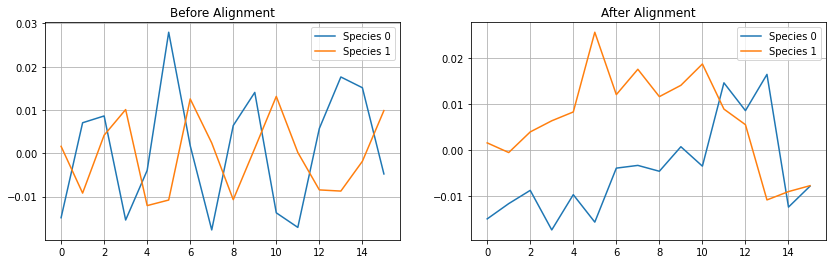

In [384]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

k = 0
ax = axs[0]
ax.plot(xc[::2, k], label="Species 0")
ax.plot(xc[1::2, k], label="Species 1")
ax.legend();
ax.set_title("Before Alignment")
ax.grid(True);

ax = axs[1]
ax.plot(yc[::2, k], label="Species 0")
ax.plot(yc[1::2, k], label="Species 1")
ax.legend();
ax.set_title("After Alignment")
ax.grid(True);


The differences are reduced by a factor of $1.3-3$. Not as dramatic as for ideal test vectors, but already significant.